In [1]:
# Financial Model

In [2]:
# Import Libraries
import sys, os
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.config_loader import load_config
cfg = load_config()
from src.report_utils import save_dataframe
from src.financials import (
    combine_solar_bess,
    annualize_revenue,
    summarize_from_annual_df,
    visualize_cashflows,
    save_summary,
    SOLAR_CAPEX,
    BESS_CAPEX,
    PROJECT_LIFE,
    DISCOUNT_RATE) 

REVENUE_ESCALATION = cfg["financials"]["escalation_rate"]
INFLATION_RATE = cfg["financials"]["inflation_rate"]
BATTERY_REPLACEMENT_YEAR = cfg["bess"]["battery_replacement_year"]
BATTERY_REPLACEMENT_COST_FRAC = cfg["bess"]["battery_replacement_cost_frac"]

OUTPUT_DIR = "../outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

print("Loaded config for project:", cfg["project"]["name"])
print("Region:", cfg["project"]["region"])
print("Project life (yrs):", PROJECT_LIFE)
print("Discount rate:", DISCOUNT_RATE)

Loaded config for project: Western NY Solar + 4-Hour BESS Feasibility Study
Region: NYISO Zone A (West NY)
Project life (yrs): 30
Discount rate: 0.07


In [3]:
# Load hourly data
solar_path  = os.path.join(OUTPUT_DIR, "solar_hourly_2024.csv")
bess_path   = os.path.join(OUTPUT_DIR, "bess_dispatch_results.csv")
price_path  = os.path.join(OUTPUT_DIR, "lbmp_zoneA_cleaned.csv")

solar_raw  = pd.read_csv(solar_path, index_col=0)
bess_raw   = pd.read_csv(bess_path,  index_col=0)
prices_raw = pd.read_csv(price_path, index_col=0)

def load_and_fix_timezone(df, name, assume_local="America/New_York"):
    """
    Robust timestamp loader for solar, BESS, and NYISO price data.
    Handles:
    - mixed timezone strings
    - missing timezone info
    - non-datetime garbage rows
    - safe conversion to UTC
    """
    df = df.copy()

    # 1. Force a full datetime conversion, drop rows that still fail
    df.index = pd.to_datetime(df.index, errors="coerce", utc=True)
    df = df[~df.index.isna()]  # drop NaT rows

    # 2. Convert from UTC to local time (if needed), then back 
    df.index = df.index.tz_convert(assume_local)
    df.index = df.index.tz_convert("UTC")

    # Clean index: sort, dedupe
    df = df[~df.index.duplicated()]
    df.sort_index(inplace=True)

    print(f"{name}: {len(df)} rows | {df.index.min()} → {df.index.max()}")
    return df

solar  = load_and_fix_timezone(solar_raw,  "Solar")
bess   = load_and_fix_timezone(bess_raw,   "BESS")
prices = load_and_fix_timezone(prices_raw, "Prices")

full_2024_index = pd.date_range(
    "2024-01-01 00:00", "2024-12-31 23:00",
    freq="h", tz="UTC"
)

solar  = solar.reindex(full_2024_index)
bess   = bess.reindex(full_2024_index)
prices = prices.reindex(full_2024_index)

# Solar: zeros at night are valid; missing values → 0
if "AC_MWh" in solar.columns:
    solar["AC_MWh"] = solar["AC_MWh"].fillna(0)

# BESS: missing dispatch hours → idle (0 revenue)
if "net_revenue_$" in bess.columns:
    bess["net_revenue_$"] = bess["net_revenue_$"].fillna(0)
if "revenue_$" in bess.columns:
    bess["revenue_$"] = bess["revenue_$"].fillna(0)

# Prices: interpolate smoothly + fill any edges
if "DAM_LBMP" in prices.columns:
    prices["DAM_LBMP"] = prices["DAM_LBMP"].interpolate(limit_direction="both")
if "RTD_LBMP" in prices.columns:
    prices["RTD_LBMP"] = prices["RTD_LBMP"].interpolate(limit_direction="both")

print("\n=== FINAL HOURLY SHAPES ===")
print("Solar: ",  solar.shape,  "| Total MWh:", solar["AC_MWh"].sum())
print("BESS:  ",  bess.shape,   "| Total $ BESS:", bess.get("net_revenue_$", 0).sum())
print("Prices:",  prices.shape, "| Mean DAM:", prices.get("DAM_LBMP", pd.Series([None])).mean())

print("\nHourly datasets are now fully aligned for revenue modeling.")

Solar: 8784 rows | 2024-01-01 05:00:00+00:00 → 2025-01-01 04:00:00+00:00
BESS: 8784 rows | 2024-01-01 05:00:00+00:00 → 2025-01-01 04:00:00+00:00
Prices: 8784 rows | 2024-01-01 05:00:00+00:00 → 2025-01-01 04:00:00+00:00

=== FINAL HOURLY SHAPES ===
Solar:  (8784, 1) | Total MWh: 1204.9040002289998
BESS:   (8784, 10) | Total $ BESS: 5059.147605263158
Prices: (8784, 10) | Mean DAM: 32.647706056466305

Hourly datasets are now fully aligned for revenue modeling.


In [4]:
if "DAM_LBMP" not in solar.columns:
    if "DAM_LBMP" in prices.columns:
        solar = solar.join(prices[["DAM_LBMP"]], how="left")
    else:
        raise KeyError("Prices DataFrame does not contain 'DAM_LBMP' column.")

print("Solar columns:", solar.columns.tolist())
print("Sample rows:")
display(solar.head())

Solar columns: ['AC_MWh', 'DAM_LBMP']
Sample rows:


,AC_MWh,DAM_LBMP
2024-01-01 00:00:00+00:00,0.0,23.67
2024-01-01 01:00:00+00:00,0.0,23.67
2024-01-01 02:00:00+00:00,0.0,23.67
2024-01-01 03:00:00+00:00,0.0,23.67
2024-01-01 04:00:00+00:00,0.0,23.67


In [5]:
# Combine revenue streams
combined = combine_solar_bess(
    solar_df=solar,
    bess_df=bess,
    price_col="DAM_LBMP"
)

print("Combined hourly dataset:")
display(combined.head())

print("\nTotal annual solar revenue: $", 
      round(combined["solar_revenue_$"].sum(), 2))

print("Total annual BESS revenue: $ ", 
      round(combined["bess_revenue_$"].sum(), 2))

print("Total revenue (solar + BESS): $ ", 
      round(combined["total_revenue_$"].sum(), 2))


Combined hourly dataset:


,AC_MWh,DAM_LBMP,price,SOC_MWh,charge_MW,discharge_MW,charge_cost_$,discharge_rev_$,net_revenue_$,throughput_MWh,charge_energy_MWh,discharge_energy_MWh,solar_revenue_$,bess_revenue_$,total_revenue_$
2024-01-01 00:00:00+00:00,0.0,23.67,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0
2024-01-01 01:00:00+00:00,0.0,23.67,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0
2024-01-01 02:00:00+00:00,0.0,23.67,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0
2024-01-01 03:00:00+00:00,0.0,23.67,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0
2024-01-01 04:00:00+00:00,0.0,23.67,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0



Total annual solar revenue: $ 38639.57
Total annual BESS revenue: $  5059.15
Total revenue (solar + BESS): $  43698.72


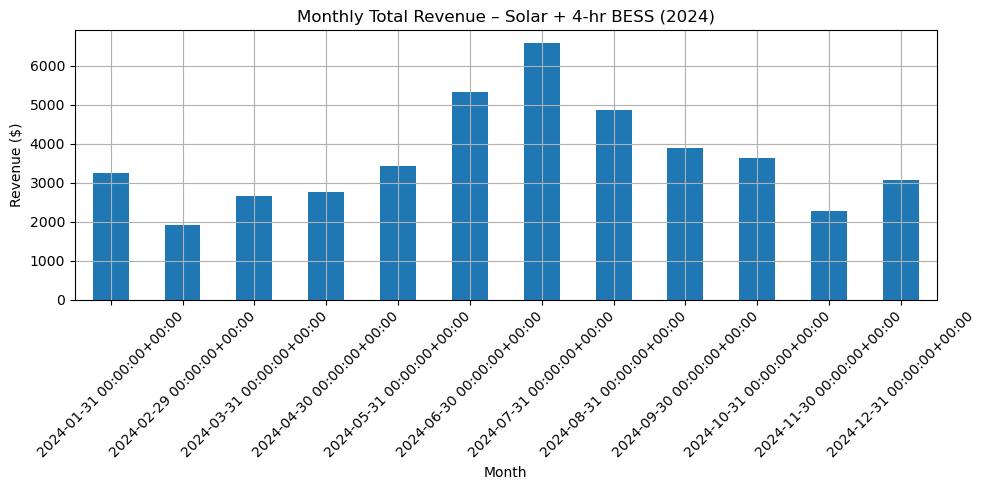

2024 total solar revenue: $ 38639.57
2024 total BESS revenue:  $ 5059.15
2024 total combined rev:  $ 43698.72


In [6]:
# Monthly view of 2024 revenue (for intuition)
monthly_rev = combined["total_revenue_$"].resample("ME").sum()

ax = monthly_rev.plot(kind="bar")
ax.set_title("Monthly Total Revenue – Solar + 4-hr BESS (2024)")
ax.set_ylabel("Revenue ($)")
ax.set_xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("2024 total solar revenue: $", round(combined["solar_revenue_$"].sum(), 2))
print("2024 total BESS revenue:  $", round(combined["bess_revenue_$"].sum(), 2))
print("2024 total combined rev:  $", round(combined["total_revenue_$"].sum(), 2))


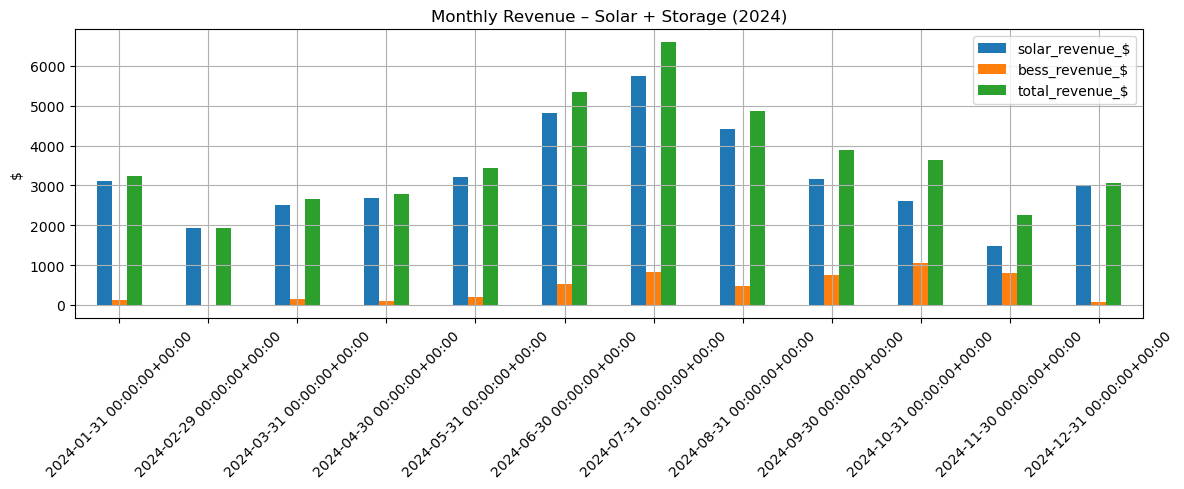

,solar_revenue_$,bess_revenue_$,total_revenue_$
2024-01-31 00:00:00+00:00,3113.147626,129.153842,3242.301468
2024-02-29 00:00:00+00:00,1925.975907,-5.750789,1920.225118
2024-03-31 00:00:00+00:00,2509.776575,151.938316,2661.714891
2024-04-30 00:00:00+00:00,2674.861233,96.054105,2770.915338
2024-05-31 00:00:00+00:00,3221.898122,209.877737,3431.775859
2024-06-30 00:00:00+00:00,4819.744842,524.257316,5344.002158
2024-07-31 00:00:00+00:00,5746.633526,838.426500,6585.060026
2024-08-31 00:00:00+00:00,4401.898362,462.801605,4864.699967
2024-09-30 00:00:00+00:00,3151.693334,742.393105,3894.086439
2024-10-31 00:00:00+00:00,2596.947765,1050.703316,3647.651081


In [7]:
monthly = combined.resample("ME")[["solar_revenue_$", "bess_revenue_$", "total_revenue_$"]].sum()

monthly.plot(kind="bar", figsize=(12,5))
plt.title("Monthly Revenue – Solar + Storage (2024)")
plt.ylabel("$")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

monthly

In [8]:
# Annualize revenues (solar, BESS, total)
annual = annualize_revenue(combined)
display(annual)

base_year = annual.index.min()
base_solar = annual.loc[base_year, "solar_revenue_$"]
base_bess = annual.loc[base_year, "bess_revenue_$"]

print(f"Base Year: {base_year}")
print(f"Base Solar Revenue: ${base_solar:,.0f}")
print(f"Base BESS Revenue:  ${base_bess:,.0f}")

,solar_revenue_$,bess_revenue_$,total_revenue_$
2024,38639.573769,5059.147605,43698.721374


Base Year: 2024
Base Solar Revenue: $38,640
Base BESS Revenue:  $5,059


In [9]:
from src.financials import summarize_financials, summarize_from_annual_df

summary, cashflow_df = summarize_from_annual_df(annual)

print("=== PROJECT FINANCIAL SUMMARY ===\n")
for k, v in summary.items():
    if isinstance(v, float):
        print(f"{k:30s}: {v:,.4f}")
    else:
        print(f"{k:30s}: {v}")

=== PROJECT FINANCIAL SUMMARY ===

NPV ($M)                      : -1.9740
IRR (%)                       : -8.1375
Initial Investment ($)        : 2,100,000.0000
Solar CAPEX ($M)              : 1.2000
BESS CAPEX ($M)               : 1.8000
Discount Rate                 : 0.0700
Escalation Rate               : 0.0200
Inflation Rate                : 0.0250


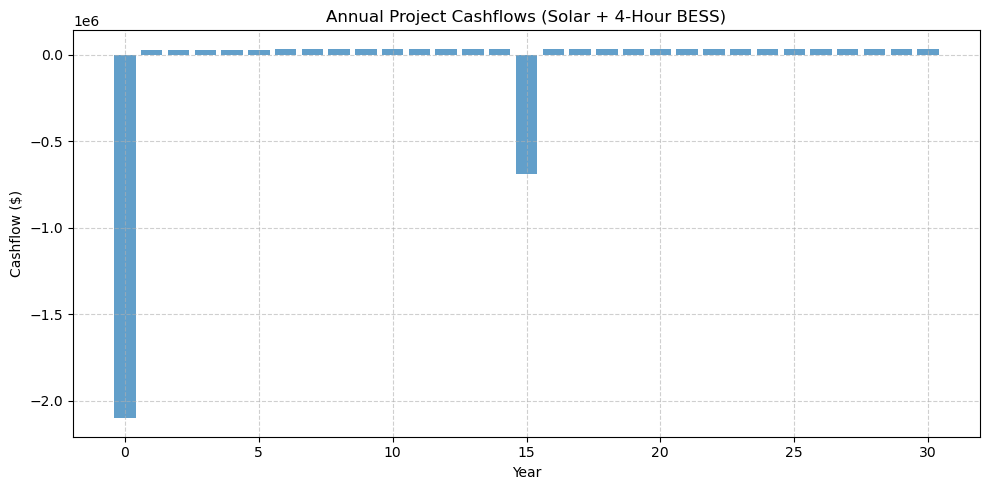

In [10]:
# Visualize full project cashflow profile
visualize_cashflows(cashflow_df)

In [11]:
### CAPEX Breakdown & Key Project Facts
capacity_mw = cfg["project"]["capacity_mw"]
duration_hours = cfg["bess"]["duration_hours"]

print("=== Project Physical Configuration ===")
print(f"Solar nameplate capacity:    {capacity_mw:.2f} MW")
print(f"BESS power rating (AC):      {capacity_mw:.2f} MW")
print(f"BESS energy capacity:        {capacity_mw * duration_hours:.2f} MWh")
print(f"BESS duration:               {duration_hours} hours")

print("\n=== CAPEX Breakdown ===")
print(f"PV CAPEX:                    ${SOLAR_CAPEX:,.0f}")
print(f"BESS CAPEX:                  ${BESS_CAPEX:,.0f}")
print(f"Total CAPEX:                 ${SOLAR_CAPEX + BESS_CAPEX:,.0f}")

print("\n=== Economic Assumptions ===")
print(f"Discount rate (nominal):     {DISCOUNT_RATE:.2%}")
print(f"Revenue escalation rate:     {REVENUE_ESCALATION:.2%}")
print(f"Inflation (O&M escalation):  {INFLATION_RATE:.2%}")
print(f"Battery replacement year:    {BATTERY_REPLACEMENT_YEAR}")
print(f"BESS replacement cost frac:  {BATTERY_REPLACEMENT_COST_FRAC:.0%}")

=== Project Physical Configuration ===
Solar nameplate capacity:    1.00 MW
BESS power rating (AC):      1.00 MW
BESS energy capacity:        4.00 MWh
BESS duration:               4 hours

=== CAPEX Breakdown ===
PV CAPEX:                    $1,200,000
BESS CAPEX:                  $1,800,000
Total CAPEX:                 $3,000,000

=== Economic Assumptions ===
Discount rate (nominal):     7.00%
Revenue escalation rate:     2.00%
Inflation (O&M escalation):  2.50%
Battery replacement year:    15
BESS replacement cost frac:  40%


In [12]:
### Solar Production Profile
total_mwh = solar["AC_MWh"].sum()
capacity_factor = total_mwh / (capacity_mw * 8760)

print("=== SOLAR PRODUCTION CHARACTERISTICS ===")
print(f"Annual MWh delivered:        {total_mwh:,.1f} MWh")
print(f"Capacity Factor:             {capacity_factor:.2%}")

=== SOLAR PRODUCTION CHARACTERISTICS ===
Annual MWh delivered:        1,204.9 MWh
Capacity Factor:             13.75%


In [13]:
### Battery Performance
bess_net = combined["bess_revenue_$"].sum()
bess_cycles = (bess["energy_throughput_MWh"].sum()
               / (capacity_mw * duration)
               if "energy_throughput_MWh" in bess.columns
               else np.nan)

print("=== STORAGE PERFORMANCE ===")
print(f"Annual BESS Net Revenue:     ${bess_net:,.0f}")
print(f"Estimated annual cycles:     {bess_cycles:,.1f} cycles/year")

=== STORAGE PERFORMANCE ===
Annual BESS Net Revenue:     $5,059
Estimated annual cycles:     nan cycles/year


In [14]:
# Simple payback
cumulative = cashflow_df["Cashflow"].cumsum()
try:
    simple_payback = cumulative[cumulative >= 0].index[0]
except:
    simple_payback = None

# Profitability Index (PI)
pi = (summary["NPV ($M)"]*1_000_000 + summary["Initial Investment ($)"]) \
     / summary["Initial Investment ($)"]

print("=== PROJECT ECONOMIC METRICS ===")
print(f"Simple Payback (yrs):        {simple_payback}")
print(f"Profitability Index (PI):    {pi:.3f}")

=== PROJECT ECONOMIC METRICS ===
Simple Payback (yrs):        None
Profitability Index (PI):    0.060


In [15]:
from src.financials import save_summary

annual.to_csv(os.path.join(OUTPUT_DIR, "annual_revenue_breakdown.csv"))
cashflow_df.to_csv(os.path.join(OUTPUT_DIR, "cashflow_table.csv"), index=False)
save_summary(summary, OUTPUT_DIR)

print(f"\nOutputs saved to: {os.path.abspath(OUTPUT_DIR)}")


Outputs saved to: C:\Users\olena\solar_finance_model\outputs
